In [1]:
## Chapter 12 Metrics and Classification Evaluation
import warnings
warnings.filterwarnings('ignore')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)

In [3]:
url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

In [5]:
def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

In [6]:
ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [8]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [9]:
y_predict = dt.predict(X_test)
tp = (
    (y_test == 1) & (y_test == y_predict)
).sum()  # 123
tn = (
    (y_test == 0) & (y_test == y_predict)
).sum()  # 199
fp = (
    (y_test == 0) & (y_test != y_predict)
).sum()  # 25
fn = (
    (y_test == 1) & (y_test != y_predict)
).sum()  # 46

## Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
y_predict = dt.predict(X_test)
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=[
        "Predict died",
        "Predict Survive",
    ],
    index=["True Death", "True Survive"],
)

,Predict died,Predict Survive
True Death,199,25
True Survive,48,121


In [12]:
(tp + tn) / (tp + tn + fp + fn)

0.8142493638676844

## Accuracy

In [15]:
from sklearn.metrics import accuracy_score
y_predict = dt.predict(X_test)
accuracy_score(y_test, y_predict)

0.8142493638676844

## Recall

In [16]:
tp / (tp + fn)
from sklearn.metrics import recall_score
y_predict = dt.predict(X_test)
recall_score(y_test, y_predict)

0.7159763313609467

## Precision

In [17]:
tp / (tp + fp)
from sklearn.metrics import precision_score
y_predict = dt.predict(X_test)
precision_score(y_test, y_predict)

0.8287671232876712

## F1 score

In [13]:
pre = tp / (tp + fp)
rec = tp / (tp + fn)
(2 * pre * rec) / (pre + rec)
from sklearn.metrics import f1_score
y_predict = dt.predict(X_test)
f1_score(y_test, y_predict)

0.7682539682539683

## ROC

In [14]:
from sklearn.metrics import roc_auc_score
y_predict = dt.predict(X_test)
roc_auc_score(y_test, y_predict)

0.8021845942519018

In [22]:
from sklearn.metrics import (
    average_precision_score,
)
y_predict = dt.predict(X_test)
average_precision_score(y_test, y_predict)

0.7155150490642249

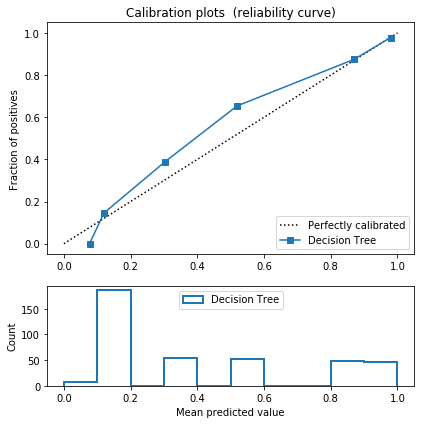

In [16]:
from sklearn.calibration import (
    calibration_curve,
)
def calib_plot(clf, name, X_test):
    fig = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot2grid(
        (3, 1), (0, 0), rowspan=2
    )
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(
        [0, 1],
        [0, 1],
        "k:",
        label="Perfectly calibrated",
    )
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[
            :, 1
        ]
    else:  # use decision function
        prob_pos = clf.decision_function(
            X_test
        )
        prob_pos = (
            prob_pos - prob_pos.min()
        ) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    ax1.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label="%s" % (name,),
    )
    ax2.hist(
        prob_pos,
        range=(0, 1),
        bins=10,
        label=name,
        histtype="step",
        lw=2,
    )
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(
        "Calibration plots  (reliability curve)"
    )
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    plt.tight_layout()
    plt.show()
    return fig
fig = calib_plot(dt, "Decision Tree", X_test)
#fig.savefig("images/cp.png", dpi=300)